<a href="https://colab.research.google.com/github/felipequinto/Series_temporais_TCC/blob/main/AnalysisStep1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Base de dados

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from keras import backend as K
import keras

In [ ]:
def fix_seeds():
  seed = 10
  os.environ['PYTHONHASHSEED']=str(seed)
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)
  keras.utils.set_random_seed(seed)

In [ ]:
df = pd.read_excel("df.xlsx")
df.head()

,Ano,Mês,Total Mês,311110101,311110103,311110105,311110106,311110107,311110108,311110109,...,3322101AC,3322101AD,3322101AE,3322101AF,3322101AG,3322101AL,3322101AM,3322101AN,3322101AO,3322101AP
0,2018,1,5.374127e+07,5906414.43,50696.18,3168486.01,6458.9,583325.63,82950.58,881.31,...,643303.97,0.0,42021.00,397621.11,436.13,18669.00,12828.98,0.00,0.0,0.0
1,2018,2,6.643437e+07,6315178.74,60144.70,730433.51,9227.0,559751.51,30982.78,2487.57,...,1321919.90,0.0,221.00,3049390.18,627.19,0.00,26629.37,0.00,0.0,0.0
2,2018,3,9.245592e+07,6328579.51,59968.33,978174.27,9227.0,625780.82,53689.57,3149.16,...,2133666.55,0.0,90120.00,1988535.08,100.80,23336.04,13739.47,8878.77,0.0,0.0
3,2018,4,1.716713e+08,6543779.23,60494.86,853728.88,0.0,598860.32,35190.27,3244.84,...,567036.15,0.0,1285864.36,6125397.66,5048.27,1555.68,65466.50,0.00,0.0,0.0
4,2018,5,6.793400e+07,7106888.05,63273.68,1057232.06,0.0,701784.14,40353.27,3235.61,...,774500.00,0.0,69562.00,8107928.05,6762.80,1555.68,0.00,0.00,0.0,0.0


In [ ]:
df_step1 = df[['Ano', 'Mês', 'Total Mês']]
df_step1.head()

,Ano,Mês,Total Mês
0,2018,1,5.374127e+07
1,2018,2,6.643437e+07
2,2018,3,9.245592e+07
3,2018,4,1.716713e+08
4,2018,5,6.793400e+07


### Organizando os dados para entrada do modelo

In [ ]:
len(df_step1['Total Mês'])

27

In [ ]:
from sklearn.preprocessing import MinMaxScaler

fix_seeds()
scaler = MinMaxScaler()
all_data_scaled = scaler.fit_transform(np.expand_dims(df_step1['Total Mês'], axis=-1))
all_data_scaled = all_data_scaled.squeeze(-1)

In [ ]:
dados_interesse = all_data_scaled  #df_step1['Total Mês']

window = 5
dataSize = len(dados_interesse)
X = []
y = []
for i in range(window, dataSize):
    X.append(dados_interesse[i-window:i])  #.values)
    y.append(dados_interesse[i])
X, y = np.array(X), np.array(y)

In [ ]:
X.shape, y.shape

((22, 5), (22,))

###Separação treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

fix_seeds()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15, 5), (7, 5), (15,), (7,))

In [ ]:
X_train[0], X_test[0]

(array([1.        , 0.30931902, 0.25592722, 0.29968588, 0.43773191]),
 array([0.        , 0.03751557, 0.11442459, 0.34855259, 0.04194787]))

### Normalização

In [ ]:
X_train_scaled = X_train
X_test_scaled = X_test
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# y_train_reshape = y_train.reshape(-1,1)
# y_test_reshape = y_test.reshape(-1,1)

# scaler_y = MinMaxScaler()
# y_train_scaled = scaler_y.fit_transform(y_train_reshape)
# y_test_scaled = scaler_y.transform(y_test_reshape)

###Modelos

#### Modelo Random Forest

In [ ]:
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import matplotlib.pyplot as plt

# Transformação opcional em y (log-transformação)
# log_transform = True
# if log_transform:
#     y_train_transformed = np.log1p(y_train)  # Aplicar log(1 + y) no treino
#     y_test_transformed = np.log1p(y_test)   # Aplicar log(1 + y) no teste
# else:
#     y_train_transformed = y_train
#     y_test_transformed = y_test

# Espaço de hiperparâmetros ampliado para RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 500, 1000],  # Quantidade de árvores na floresta
    'max_depth': [10, 50, None],  # Limitar ou não a profundidade máxima
    'min_samples_split': [2, 10],  # Amostras mínimas para dividir
    'min_samples_leaf': [1, 2, 20],    # Amostras mínimas por folha
    'max_features': ['sqrt', 'log2', None]  # Variáveis por nó
}

# Inicializar o modelo base
regressor = RandomForestRegressor(random_state=0)

# Ajuste de hiperparâmetros com RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_distributions,
    n_iter=100,  # Número de combinações testadas
    scoring='neg_mean_squared_error',  # Métrica de avaliação
    cv=2,  # Validação cruzada com 5 dobras
    verbose=2,
    n_jobs=-1,  # Paralelismo máximo
    random_state=42
)

# Ajustar o modelo aos dados normalizados
random_search.fit(X_train_scaled, y_train)

# Melhor modelo encontrado
best_model = random_search.best_estimator_

# Previsões no conjunto de teste
y_pred = best_model.predict(X_test)

# Reverter a transformação logarítmica, se aplicável
# if log_transform:
#     y_pred_metrics = np.expm1(y_pred)  # Reverter log(1 + y)
#     y_test_metrics = np.expm1(y_test_transformed)
# else:
#     y_pred_metrics = y_pred
#     y_test_metrics = y_test_transformed

Fitting 2 folds for each of 100 candidates, totalling 200 fits


In [ ]:
y_pred_metrics = scaler.inverse_transform(np.expand_dims(y_pred, axis=-1))
y_test_metrics = scaler.inverse_transform(np.expand_dims(y_test, axis=-1))

In [ ]:
# Avaliação do modelo
rmse = math.sqrt(mean_squared_error(y_test_metrics, y_pred_metrics))
mse = mean_squared_error(y_test_metrics, y_pred_metrics)
mape = np.mean(np.abs((y_test_metrics - y_pred_metrics) / (y_test_metrics + 1e-10))) * 100
r2 = r2_score(y_test_metrics, y_pred_metrics)

# Validação cruzada no treino
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -np.mean(cv_scores)

# Exibição dos resultados
print("Melhores hiperparâmetros encontrados:", random_search.best_params_)
print("MSE médio da validação cruzada (treino):", mean_cv_mse)
print('RMSE (teste):', rmse)
print('MSE (teste):', mse)
print('MAPE (teste):', mape, '%')
print('R² (teste):', r2)

Melhores hiperparâmetros encontrados: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
MSE médio da validação cruzada (treino): 0.07300273597179299
RMSE (teste): 88736075.36312072
MSE (teste): 7874091070849439.0
MAPE (teste): 76.0195588730425 %
R² (teste): -2.839017269346797


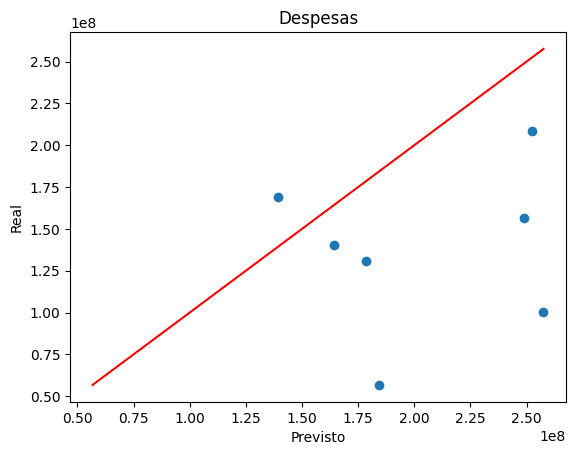

In [ ]:
plt.scatter(y_pred_metrics, y_test_metrics)
plt.ylabel("Real")
plt.xlabel("Previsto")
plt.title("Despesas")

x = [min(y_pred_metrics.min(), y_test_metrics.min()), max(y_pred_metrics.max(), y_test_metrics.max())]
plt.plot(x, x, color='red')  # Linha de referência y = x

plt.show()

#### Modelo Redes Neurais

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv1D, Flatten

In [ ]:
X_train_scaled_reshaped = np.expand_dims(X_train_scaled, 2)
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, 2)
X_train_scaled_reshaped.shape

(15, 5, 1)

In [ ]:
# Inicializa a RNN
fix_seeds()
regressor = Sequential()

# Adiciona a primeira camada LSTM e Dropout
regressor.add(LSTM(units=2, return_sequences=True, input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])))
regressor.add(BatchNormalization())
# regressor.add(LSTM(units=2, return_sequences=True))

regressor.add(Conv1D(filters=1, kernel_size=4, strides=1, padding="same", activation="relu"))

# regressor.add(BatchNormalization())
# regressor.add(Dropout(0.2))
regressor.add(Flatten())

# # Adiciona a segunda camada LSTM e Dropout
# regressor.add(LSTM(units=80, return_sequences=True))
# regressor.add(Dropout(0.2))

# Adiciona a terceira camada LSTM e Dropout
# regressor.add(LSTM(units=3))
# regressor.add(Dense(units=4))
# regressor.add(Dropout(0.2))

# Camada de saída
regressor.add(Dense(units=1))

# Compila a rede
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Visualiza a rede
regressor.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 5, 2)                │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 2)                │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 5, 1)                │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55 (220.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 4 (16.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

ES_callback = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
LR_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [ ]:
history = regressor.fit(X_train_scaled_reshaped, y_train_scaled,
                        validation_data=(X_test_scaled_reshaped, y_test_scaled),
                        epochs=200, batch_size=2, callbacks=[ES_callback,LR_callback])

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1405 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1362 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1346 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1333 - val_loss: 0.0637 - learning_rate: 0.0010
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1321 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1311 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1297 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1282 - val_loss: 0.0587 - learning_rate: 0.0010
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1269 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 10/200
8/8 ━━━━━━━━━━━

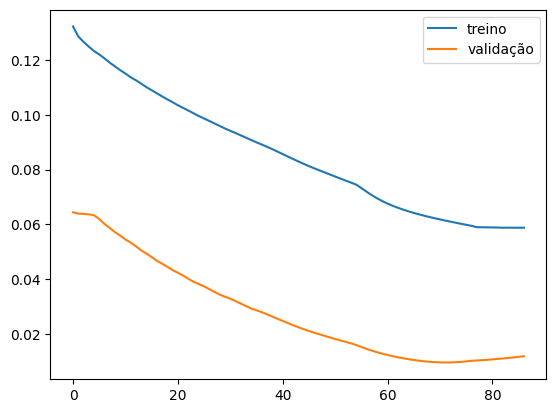

In [ ]:
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='validação')
plt.legend();

In [ ]:
X_test_scaled_reshaped.shape

(7, 5, 1)

In [ ]:
y_pred = regressor.predict(X_test_scaled_reshaped)
# y_pred = np.squeeze(y_pred, -1)
# y_pred = scaler_y.inverse_transform(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [ ]:
y_pred.shape

(7, 1)

In [ ]:
y_pred_metrics = scaler.inverse_transform(y_pred)
y_test_metrics = scaler.inverse_transform(np.expand_dims(y_test, axis=-1))

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_pred_metrics, y_test_metrics))
print('RMSE: ', rmse)

mse = mean_squared_error(y_pred_metrics, y_test_metrics)
print('MSE: ',mse)

mape = np.mean(np.abs((y_test_metrics - y_pred_metrics) / y_test_metrics)) * 100
print('MAPE: ',mape, '%')

from sklearn.metrics import r2_score
r2_score(y_pred_metrics,y_test_metrics)

RMSE:  33348900.773888126
MSE:  1112149182826636.1
MAPE:  26.365762659481014 %


-1.367855411441032

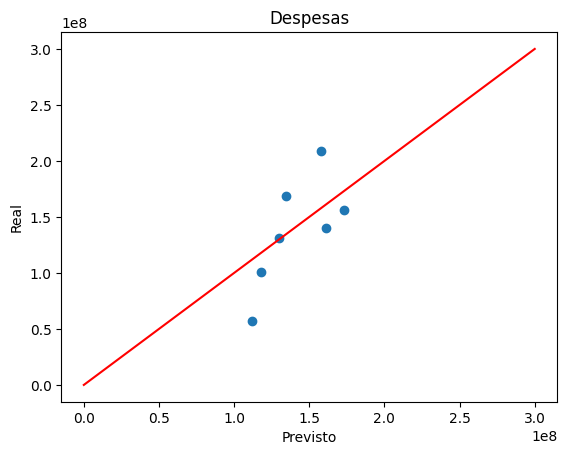

In [ ]:
plt.scatter(y_pred_metrics,y_test_metrics)
plt.ylabel("Real")
plt.xlabel("Previsto")
plt.title("Despesas")

x = [0.0, 3e8]
plt.plot(x, x, color='red'); #reta onde y=x

plt.show()

In [ ]:
X_complete_reshaped = np.expand_dims(X, 2)
y_pred_complete = regressor.predict(X_complete_reshaped)
y_pred_denormalized = scaler.inverse_transform(y_pred_complete).squeeze(-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


In [ ]:
y_denormalized = y_test_metrics = scaler.inverse_transform(np.expand_dims(y, axis=-1))

In [ ]:
y_pred_denormalized.shape

(22,)

In [ ]:
y_denormalized.shape

(22, 1)

In [ ]:
y_pred_denormalized[0], y_denormalized[0]

(111588344.0, array([56750962.17]))

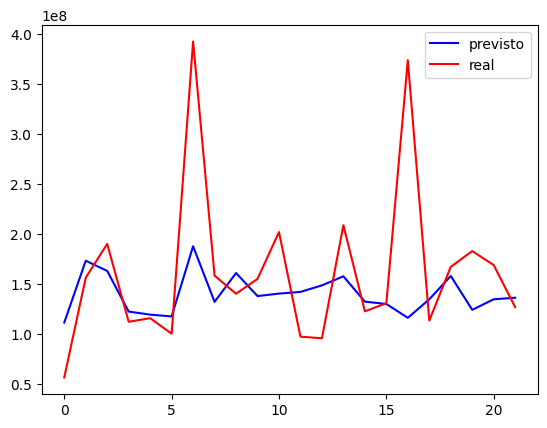

In [ ]:
plt.plot(y_pred_denormalized, color='blue', label='previsto')
plt.plot(y_denormalized, color='red', label='real')
plt.legend()
plt.show()